# Salary in First Tier Cities 一线城市工资调查
我在4月1日到3日之间，抓取了某招聘网站的软件和互联网类招聘数据40万条，其中通过程序判断为程序员的14万条。地域方面，我选择了24个主要城市。不过本文只以一线城市为研究对象。这样是为了和我2017年6月的数据做对比。

提到2017年的文章，现在居然还有很多人，把这篇文章拿出来炒作。对于社会来说，可气的是，他们直接把2017改成2019，就发表了，这不是骗人么？！对于我来说，可气的是，他们转载居然还冒充是原创，是可忍熟不可忍！

In [2]:
import pandas as pd
import db
import inspect
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
%matplotlib inline

In [3]:
conn=db.get_conn()
developers_in_24_cities=conn.execute('select count(1) from _51jobs where monthly_salary>0 and monthly_salary<15').fetchall()[0][0]
data_original=pd.read_sql(sql="select * from _51jobs where (city_beijing=1 or city_shanghai=1 or city_guangzhou=1 or city_shenzhen=1) and monthly_salary>0 and monthly_salary<15", con=conn)
conn.close()

In [4]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [5]:
del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

In [6]:
for col in data.columns:
    if col.startswith('city_') and not col in ['city_beijing','city_shanghai','city_guangzhou','city_shenzhen']:
        del data[col]

# Unilateral Stats 总体统计

In [7]:
print('{} Jobs found in all the 24 major cities in China. {} or {:.2%} of them are in the first tier cities.'.
      format(developers_in_24_cities, data.shape[0], data.shape[0]*1.0/developers_in_24_cities))

139573 Jobs found in all the 24 major cities in China. 77536 or 55.55% of them are in the first tier cities.


In [8]:
print('在24个主要城市中，共找到{}个职位，其中{}（{:.2%}）属于一线城市。'.
      format(developers_in_24_cities, data.shape[0], data.shape[0]*1.0/developers_in_24_cities))

在24个主要城市中，共找到139573个职位，其中77536（55.55%）属于一线城市。


有数据可知，程序员向一线城市集中的趋势非常明显。

According to the statistics, significant amount of developers are in the first tier cities.

In [9]:
salary_mean=data.monthly_salary.mean()*10000
salary_median=data.monthly_salary.median()*10000
q=np.quantile(data.monthly_salary,[0.025,0.975])*10000
print('2019年中国大陆一线城市程序员的平均工资为{:.0f}元，工资中位数为{:.0f}元，其中95%的人的工资位于{:.0f}到{:.0f}元之间。'
      .format(salary_mean, salary_median, q[0], q[1]))

2019年中国大陆一线城市程序员的平均工资为15716元，工资中位数为14000元，其中95%的人的工资位于5250到36500元之间。


In [10]:
print('In 2019, Developers in the first tier cities earn {:.0f} Yuan as average, '
      'the median is {:.0f} Yuan, 95% of them earn between {:.0f} and {:.0f} Yuan.'
      .format(salary_mean, salary_median, q[0], q[1]))

In 2019, Developers in the first tier cities earn 15716 Yuan as average, the median is 14000 Yuan, 95% of them earn between 5250 and 36500 Yuan.


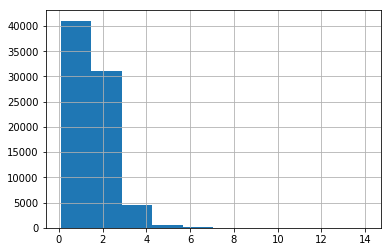

In [11]:
data.monthly_salary.hist()

It does not look like normal distribution.

In [12]:
from scipy import stats

In [13]:
stats.normaltest(data.monthly_salary)

NormaltestResult(statistic=42343.17993165874, pvalue=0.0)

null hypothesis: x comes from a normal distribution
    
p=0

The null hypothesis can be rejected

conclusion: data is not normally distributed.

Zoom in

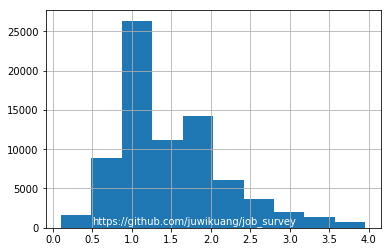

In [17]:
data[data.monthly_salary<4].monthly_salary.hist()
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0,0), xytext=(0.5, 500), color='white')
plt.show()

## Role 角色

In [19]:
def get_sub_stats(data, prefix):
    
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    salary_mean=[]
    salary_median=[]
    count=[]
    for feature in features:
        salary_mean.append(data[data[feature]==1].monthly_salary.mean()*10000)
        salary_median.append(data[data[feature]==1].monthly_salary.median()*10000)
        count.append(data[data[feature]==1].shape[0])
    sub_data=pd.DataFrame()
    sub_data[prefix]=[f.replace(prefix,'') for f in features]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_median']=salary_median
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data


    

In [20]:
def add_category_column(data, prefix):
    prefix_=prefix+"_"
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    data.loc[:,prefix]=['']*data.shape[0]
    for feature in features:
        data.loc[data[feature]==1,prefix]=feature.replace(prefix_,'')
    #data[prefix]=new_column
    return data

In [21]:
data_career=get_sub_stats(data,'career_')
data_career.style.format({"percentage":"{:.2%}"})

,career_,salary_mean,salary_median,head_count,percentage
1,architect,24003.4,22500,3810,4.78%
0,algorithm,23149.6,22500,9306,11.67%
2,software_engineer,14575.9,12500,66605,83.55%


有表可知，架构师的工资平均为2.1万，算法工程师为2万，普通程序员为1万4。


In [22]:
career_architect_salary=data[data.career_architect==1].monthly_salary
career_algorithm_salary=data[data.career_algorithm==1].monthly_salary
career_software_engineer_salary=data[data.career_software_engineer==1].monthly_salary
stats.f_oneway(career_algorithm_salary, career_software_engineer_salary)

F_onewayResult(statistic=10318.190675760517, pvalue=0.0)

In [23]:
stats.f_oneway(career_architect_salary, career_algorithm_salary)

F_onewayResult(statistic=15.425156918591176, pvalue=8.627749154400873e-05)

统计表面，架构师，算法工程师，普通程序员之间的平均工资差异是显著的。

# 编程语言

In [24]:
data_pl=get_sub_stats(data,'pl_')
data_pl.style.format({"percentage":"{:.2%}"})

,pl_,salary_mean,salary_median,head_count,percentage
6,haskell,25666.7,26250,10,0.01%
9,julia,23750,23750,2,0.00%
18,rust,22746.5,20000,95,0.09%
19,scala,22622,20833.3,917,0.88%
5,groovy,20411.7,17500,50,0.05%
12,matlab,19937.8,17500,1522,1.46%
16,python,19708.6,17500,9355,8.97%
4,go,19388.2,17500,8298,7.96%
25,r,19366,17500,400,0.38%
14,perl,18748.3,17500,920,0.88%


数据显示，haskell才是最赚钱的编程语言。python是主流语言里面最赚钱的，比java的工资多了3000元！vb是最不赚钱的了。其中，最赚钱的编程语言和最不赚钱的，工资居然差了2倍。所以，要选好编程语言呀！

# 教育

In [25]:
data_edu=get_sub_stats(data,'edu_')
data_edu.style.format({"percentage":"{:.2%}"})

,edu_,salary_mean,salary_median,head_count,percentage
5,phd,30308,29000,112,0.17%
3,master,23084.4,21000,2051,3.13%
1,bachelor,16840.8,15000,42268,64.50%
0,associate,12828.3,12500,20879,31.86%
4,middle_school,11798.1,7000,26,0.04%
2,high_school,9580.51,7000,195,0.30%


大专，本科，硕士，博士的平均工资分别是12828，16840，23084，30308。中位数分别是12500， 15000，21000， 29000。

In [26]:
salary_phd=data[data.edu_phd==1].monthly_salary
salary_master=data[data.edu_master==1].monthly_salary
salary_bachelor=data[data.edu_bachelor==1].monthly_salary
salary_associate=data[data.edu_associate==1].monthly_salary

In [27]:
stats.f_oneway(salary_phd, salary_master)

F_onewayResult(statistic=37.99934598382358, pvalue=8.419586730682308e-10)

In [28]:
stats.f_oneway(salary_master, salary_bachelor)

F_onewayResult(statistic=1039.3610697025629, pvalue=2.0403673390552008e-225)

In [29]:
stats.f_oneway(salary_bachelor, salary_associate)

F_onewayResult(statistic=3866.5985931587775, pvalue=0.0)

In [30]:
%watermark --iversions

UsageError: Line magic function `%watermark` not found.


经过Oneway Anova Test，证明从大专到博士，学历每提高一级，工资都有显著的提高。

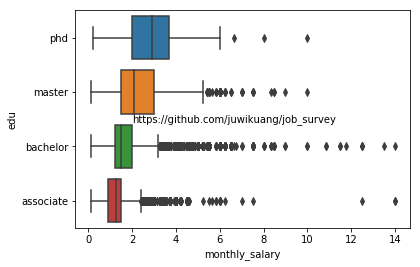

In [49]:
data=add_category_column(data,'edu')
order=['phd','master','bachelor','associate']
a=sns.boxplot(y='edu',x='monthly_salary',order=order,data=data[data.edu.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0.5,1.5), xytext=(2, 1.55))
plt.show()

# 工作经验 Working Experience

In [32]:
data_experience=get_sub_stats(data,'experience_')
data_experience.style.format({"percentage":"{:.2%}"})

,experience_,salary_mean,salary_median,head_count,percentage
0,10,32645.6,30000,305,0.39%
3,5_10,22569.4,20500,11100,14.32%
2,3_5,16587.6,15000,23940,30.88%
4,no,14244.6,12500,18327,23.64%
1,1_3,12567.8,11500,23864,30.78%


In [33]:
salary_we_10=data[data.experience_10==1].monthly_salary * 10000
salary_we_5_10=data[data.experience_5_10==1].monthly_salary * 10000
salary_we_3_5=data[data.experience_3_5==1].monthly_salary * 10000
salary_we_1_3=data[data.experience_1_3==1].monthly_salary * 10000
salary_we_no=data[data.experience_no==1].monthly_salary * 10000

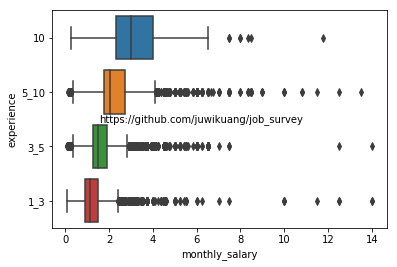

In [34]:
data=add_category_column(data,'experience')
order=['10','5_10','3_5','1_3']
sns.boxplot(y='experience',x='monthly_salary',order=order,data=data[data.experience.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(1.5,1.5), xytext=(1.55, 1.55))
plt.show()

数据显示，工资会随着工作经验的增长而增长。不过，我感觉那些招十年工作经验的，基本上都是架构师等职位。如果你的工作经验是一年的工作经验重复十次，应该拿不到那么高的工资。这个以后我还会仔细分析。

# 城市 City

In [35]:
data_city=get_sub_stats(data,'city_')
data_city.style.format({"percentage":"{:.2%}"})

,city_,salary_mean,salary_median,head_count,percentage
0,beijing,17453.1,15000,13823,17.83%
2,shanghai,16626.4,15000,25888,33.39%
3,shenzhen,15631.3,14000,20757,26.77%
1,guangzhou,13031.7,12000,17068,22.01%


程序员收入最高的城市分别为：北京，上海，深圳，广州

In [36]:
salary_beijing=data[data.city_beijing==1].monthly_salary
salary_shanghai=data[data.city_shanghai==1].monthly_salary
salary_guangzhou=data[data.city_guangzhou==1].monthly_salary
salary_shenzhen=data[data.city_shenzhen==1].monthly_salary

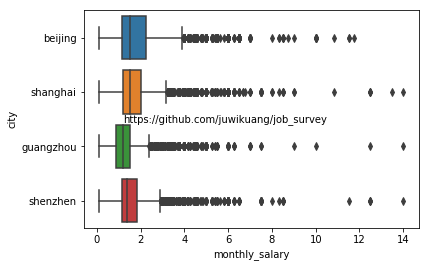

In [37]:
data=add_category_column(data,'city')
order=['shenzhen','guangzhou','shanghai','beijing']
order=['beijing','shanghai','guangzhou','shenzhen']

sns.boxplot(y='city',x='monthly_salary',order=order,data=data[data.city.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0.5,1.5), xytext=(1.2, 1.55))
plt.show()

In [38]:
stats.f_oneway(salary_beijing, salary_shanghai)

F_onewayResult(statistic=80.32434741890425, pvalue=3.3121643665903536e-19)

In [39]:
stats.f_oneway(salary_shanghai, salary_guangzhou)

F_onewayResult(statistic=2290.0597614426306, pvalue=0.0)

In [40]:
stats.f_oneway(salary_guangzhou, salary_shenzhen)

F_onewayResult(statistic=1191.135261747661, pvalue=5.103034674562747e-257)

统计（Oneway Anova）显示，任何两个城市之间的平均工资差异都是显著的。

The average salary between the four cities are significant different.

In [41]:
data_city.sort_values(by='head_count', ascending=False).style.format({"percentage":"{:.2%}"})

,city_,salary_mean,salary_median,head_count,percentage
2,shanghai,16626.4,15000,25888,33.39%
3,shenzhen,15631.3,14000,20757,26.77%
1,guangzhou,13031.7,12000,17068,22.01%
0,beijing,17453.1,15000,13823,17.83%


<BarContainer object of 4 artists>

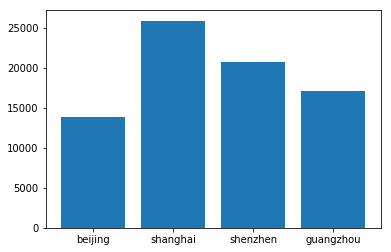

In [42]:
plt.bar(data_city.city_, data_city.head_count)

# 公司 Company

## 公司性质 Company Type

In [43]:
data_company_type=get_sub_stats(data,'company_type_')
data_company_type.style.format({"percentage":"{:.2%}"})

,company_type_,salary_mean,salary_median,head_count,percentage
9,us_eu,18301.1,17500,3531,4.96%
7,startup,16353.1,15000,1777,2.50%
3,listed,16278.8,15000,7197,10.12%
2,foreign_rep,15714.3,12500,56,0.08%
8,state,15500.8,14000,3795,5.33%
5,private,15451.8,13000,50380,70.81%
0,foreign,15226.2,12500,3895,5.47%
6,public_institution,14149.4,12500,436,0.61%
4,non_profit,11548.8,10500,70,0.10%
1,foreign_gov,10527.8,7000,9,0.01%


us_eu是欧美外企，startup是创业公司，listed是上市公司，state是国企，private是私企，foreign是非欧美外企，其他不足1000个样本的不管了。

In [44]:
salary_us_eu=data[data.company_type_us_eu==1].monthly_salary
salary_startup=data[data.company_type_startup==1].monthly_salary
salary_listed=data[data.company_type_listed==1].monthly_salary

In [45]:
stats.f_oneway(salary_us_eu,salary_startup)

F_onewayResult(statistic=53.96465474051579, pvalue=2.351111467004394e-13)

In [46]:
stats.f_oneway(salary_us_eu,salary_listed)

F_onewayResult(statistic=146.1796365323301, pvalue=1.9559438664827014e-33)

由上报可知，欧美外企的工资显著高于其他企业。比创业公司和上司公司足足高了2000元呀。要努力学好英语呀！

顺便做个广告，大家如果想通过看美剧或者看英文书提高英语，可以上我的网站，美剧单词网。里面会把你不懂的单词列出来，你再去听美剧，听英语有声书（网站提供），就能听懂了。

https://www.tvshowwords.com/


## 公司规模 Company Size

In [47]:
data_company_size=get_sub_stats(data,'company_size_')
data_company_size.style.format({"percentage":"{:.2%}"})

,company_size_,salary_mean,salary_median,head_count,percentage
0,10000,21269.5,17500,3676,4.76%
1,1000_5000,16960,15000,10858,14.06%
4,5000_10000,16854.4,15000,1784,2.31%
5,500_1000,16762.5,15000,8274,10.71%
2,150_500,15714.7,14000,17839,23.09%
6,50_150,14682.2,12500,22547,29.19%
3,50,13900.6,12500,12268,15.88%


公司越大，工资越高

## 行业 Industry

In [48]:
data_industry=get_sub_stats(data,'industry_')
data_industry.style.format({"percentage":"{:.2%}"})

,industry_,salary_mean,salary_median,head_count,percentage
4,finance,17488.9,16000,3766,3.99%
2,edu,17159.8,15000,5812,6.16%
9,service,16134.1,14583.3,933,0.99%
6,logistic,15996.2,14000,1350,1.43%
1,computer,15752.1,14000,65762,69.72%
5,gov,15275.6,12500,1954,2.07%
10,trade,15062.7,12500,7199,7.63%
7,medical,14738.3,13000,2386,2.53%
8,realestate,14676.8,12500,1710,1.81%
0,ads,14406.6,12500,1815,1.92%


金融业果然是工资最高的。